Data preparation and data clearning

In [314]:
import pandas as pd
import pyarrow.parquet as pq
import os

def read_parquet_files_to_dataframe(directory_path):
    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.endswith('.parquet')]
    
    # Initialize an empty list to hold DataFrames
    dataframes = []
    
    # Loop through the files and read each one into a DataFrame
    for file in files:
        file_path = os.path.join(directory_path, file)
        parquet_file = pq.ParquetFile(file_path)
        df = parquet_file.read().to_pandas()
        dataframes.append(df)
    
    # Concatenate all the DataFrames into a single DataFrame
    merged_dataframe = pd.concat(dataframes, ignore_index=True)
    
    return merged_dataframe



# Call the function
merged_dataframe = read_parquet_files_to_dataframe('tmdb/')
pd.set_option("max_colwidth", None)
pd.set_option('display.max_columns', None)

In [315]:
merged_dataframe=merged_dataframe.drop_duplicates(subset=['id'])
print(merged_dataframe.shape)

(6758, 59)


In [310]:

merged_dataframe.to_parquet('data/movies.parquet', compression='gzip')

In [275]:
merged_dataframe[merged_dataframe['original_title'] != merged_dataframe['title']][['title', 'original_title']].head(10)

,title,original_title
1,Jamon Jamon,"Jamón, jamón"
5,My Best Friend,Mon Meilleur Ami
8,Conversations with My Gardener,Dialogue avec mon jardinier
11,"Death Is Nimble, Death Is Quick",Kommissar X - Drei gelbe Katzen
12,"Kiss Kiss, Kill Kill",Kommissar X - Jagd auf Unbekannt
13,The Count of Monte Cristo,Le Comte de Monte-Cristo
14,The Defector,L'espion
15,"So Darling, So Deadly",Kommissar X - In den Klauen des goldenen Drachen
16,Kill Me Gently,Kommissar X - Drei grüne Hunde
17,"Kill, Panther, Kill!",Kommissar X - Drei blaue Panther


In [276]:
merged_dataframe['adult'].value_counts()

adult
False    3537
True       11
Name: count, dtype: int64

In [277]:
merged_dataframe['status'].value_counts()

status
Released           3547
Post Production       1
Name: count, dtype: int64

In [278]:
# Franchise Movies - I think it can be also a good feature
merged_dataframe[merged_dataframe['belongs_to_collection'].notnull()]

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,Type,totalSeasons,Response,DVD,BoxOffice,Production,Website,belongs_to_collection.id,belongs_to_collection.name,belongs_to_collection.poster_path,belongs_to_collection.backdrop_path,Season,Episode,seriesID


In [279]:
def extract_rating(ratings, source):
    for rating in ratings:
        if rating['Source'] == source:
            return rating['Value']
    return None

df = merged_dataframe[['id', 'title', 'release_date', "original_language" , 'spoken_languages', 'genres',
                       'production_companies',  'production_countries', 'runtime', 'status', 'Rated',
                       'budget', 'revenue', 'BoxOffice', 'popularity', 'vote_average', 'vote_count',
                         'Awards', 'Ratings', 'Metascore', 'imdbRating',
       'imdbVotes']].copy()

df = df[df['status'].str.lower() == 'released']

df['Rotten_Tomatoes_Rating'] = df['Ratings'].apply(lambda x: extract_rating(x, 'Rotten Tomatoes')) 
df['genres'] = df['genres'].apply(lambda x: ', '.join([d['name'] for d in x]))
df['production_companies'] = df['production_companies'].apply(lambda x: ','.join([d['name'] for d in x]))
df['production_countries'] = df['production_countries'].apply(lambda x: ','.join([d['iso_3166_1'] for d in x]))
df['spoken_languages'] = df['spoken_languages'].apply(lambda x: ','.join([d['iso_639_1'] for d in x]))
df['release_month'] = pd.to_datetime(df['release_date']).dt.month
df['release_year'] = pd.to_datetime(df['release_date']).dt.year

df.drop(['release_date', 'Ratings', 'status'], axis=1, inplace=True)

# Standardize column names
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.rename(columns={"popularity": "tmdb_popularity", "vote_average": "tmdb_vote_average",
                     "vote_count": "tmdb_vote_count", 'metascore': 'metacritic_rating',
                     "imdbrating": "imdb_rating", 'imdbvotes': 'imdb_votes'}, inplace=True)

df['boxoffice'] = df['boxoffice'].str.replace('$', '')
df['boxoffice'] = df['boxoffice'].str.replace(',', '')
df['boxoffice'] = pd.to_numeric(df['boxoffice'], errors='coerce')

df['rotten_tomatoes_rating'] = df['rotten_tomatoes_rating'].str.replace('%', '')

df['imdb_rating'] = pd.to_numeric(df['imdb_rating'], errors='coerce')
df['imdb_votes'] = df['imdb_votes'].str.replace(',', '')
df['imdb_votes'] = pd.to_numeric(df['imdb_votes'], errors='coerce')
df['rotten_tomatoes_rating'] = pd.to_numeric(df['rotten_tomatoes_rating'], errors='coerce')
df['metacritic_rating'] = pd.to_numeric(df['metacritic_rating'], errors='coerce')


categorical_vars = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_vars:
    df[c] = df[c].str.lower()

df


,id,title,original_language,spoken_languages,genres,production_companies,production_countries,runtime,rated,budget,revenue,boxoffice,tmdb_popularity,tmdb_vote_average,tmdb_vote_count,awards,metacritic_rating,imdb_rating,imdb_votes,rotten_tomatoes_rating,release_month,release_year
0,4501,der fall rohrbach,de,de,drama,,de,270,n/a,0,0,NaN,1.09,0.00,0,n/a,NaN,9.10,15.00,NaN,5,1963
1,4507,jamon jamon,es,es,"comedy, drama, romance","ovídeo tv s.a.,sogepaq,lolafilms",es,95,r,0,0,938473.00,16.88,6.22,306,6 wins & 12 nominations,NaN,6.40,14634.00,69.00,9,1992
2,4512,the assassination of jesse james by the coward robert ford,en,en,"action, drama, western","plan b entertainment,virtual studios,scott free productions,alberta film entertainment,jesse films inc.,warner bros. pictures","ca,gb,us",160,r,30000000,14711793,3909149.00,22.56,7.05,2276,nominated for 2 oscars. 25 wins & 69 nominations total,68.00,7.50,189145.00,77.00,9,2007
3,4513,30 days of night,en,en,"horror, thriller","horrorflix,columbia pictures,ghost house pictures,dark horse entertainment,mandate international","nz,us",113,r,30000000,75505973,39569000.00,31.85,6.40,2511,14 nominations,53.00,6.60,185010.00,51.00,10,2007
4,4515,lions for lambs,en,en,"action, adventure, drama, history","cruise/wagner productions,united artists,wildwood enterprises,andell entertainment,brat na pont productions,metro-goldwyn-mayer",us,92,r,35000000,64811540,15002854.00,12.71,6.02,681,3 nominations,47.00,6.20,51661.00,27.00,10,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3543,196,back to the future part iii,en,en,"adventure, comedy, science fiction","universal pictures,amblin entertainment",us,119,pg,40000000,244527583,88277583.00,31.72,7.50,9687,5 wins & 11 nominations,55.00,7.40,468495.00,80.00,5,1990
3544,197,braveheart,en,"en,fr,la,gd","action, drama, history, war","icon entertainment international,the ladd company,b.h. finance c.v.",us,177,r,72000000,213216216,75609945.00,42.17,7.93,9355,won 5 oscars. 34 wins & 34 nominations total,68.00,8.30,1069827.00,76.00,5,1995
3545,198,to be or not to be,en,"en,de","comedy, war",united artists,us,99,passed,1200000,1500000,3270000.00,11.81,7.89,630,nominated for 1 oscar. 2 wins & 2 nominations total,86.00,8.20,40902.00,96.00,3,1942
3546,199,star trek: first contact,en,en,"science fiction, action, adventure, thriller",paramount,us,111,pg-13,46000000,150000000,92027888.00,27.22,7.29,1593,nominated for 1 oscar. 8 wins & 21 nominations total,71.00,7.60,130183.00,93.00,11,1996


In [280]:
df.describe()

,id,runtime,budget,revenue,boxoffice,tmdb_popularity,tmdb_vote_average,tmdb_vote_count,metacritic_rating,imdb_rating,imdb_votes,rotten_tomatoes_rating,release_month,release_year
count,3547.00,3547.00,3547.00,3547.00,1707.00,3547.00,3547.00,3547.00,1662.00,3477.00,3492.00,2090.00,3547.00,3547.00
mean,2940.63,103.73,13140719.25,47635720.32,46929272.90,13.85,6.03,1330.90,64.89,6.59,91501.53,70.64,6.78,1984.92
std,1934.74,28.72,30207603.98,127147804.35,71453125.99,17.83,1.96,3016.77,17.75,1.13,218020.46,24.57,3.60,21.21
min,2.00,0.00,0.00,0.00,509.00,0.00,0.00,0.00,9.00,1.00,6.00,0.00,1.00,1895.00
25%,1282.50,90.00,0.00,0.00,1455270.50,2.62,5.68,12.00,52.00,6.00,618.50,55.00,4.00,1971.00
50%,2665.00,100.00,0.00,0.00,19176754.00,9.48,6.52,151.00,65.00,6.70,8980.00,77.00,7.00,1991.00
75%,4668.00,116.00,11000000.00,29611288.50,60154091.00,18.14,7.19,1144.00,78.00,7.40,82455.00,91.00,10.00,2003.00
max,6500.00,319.00,379000000.00,2264162353.00,674292608.00,302.31,10.00,30664.00,100.00,9.30,2802199.00,100.00,12.00,2014.00


In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3547 entries, 0 to 3547
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3547 non-null   int64  
 1   title                   3547 non-null   object 
 2   original_language       3547 non-null   object 
 3   spoken_languages        3547 non-null   object 
 4   genres                  3547 non-null   object 
 5   production_companies    3547 non-null   object 
 6   production_countries    3547 non-null   object 
 7   runtime                 3547 non-null   int64  
 8   rated                   3547 non-null   object 
 9   budget                  3547 non-null   int64  
 10  revenue                 3547 non-null   int64  
 11  boxoffice               1707 non-null   float64
 12  tmdb_popularity         3547 non-null   float64
 13  tmdb_vote_average       3547 non-null   float64
 14  tmdb_vote_count         3547 non-null   int64

In [282]:
df[df['budget'].isnull()].shape

(0, 22)

In [283]:
df.isnull().sum()

id                           0
title                        0
original_language            0
spoken_languages             0
genres                       0
production_companies         0
production_countries         0
runtime                      0
rated                        0
budget                       0
revenue                      0
boxoffice                 1840
tmdb_popularity              0
tmdb_vote_average            0
tmdb_vote_count              0
awards                       0
metacritic_rating         1885
imdb_rating                 70
imdb_votes                  55
rotten_tomatoes_rating    1457
release_month                0
release_year                 0
dtype: int64

In [284]:
df['id'].duplicated().sum()

ids = df['id']
duplicate_reviews = df[ids.isin(ids[ids.duplicated()])].sort_values("id")
duplicate_reviews.head(10)

# need to drop 16th row

,id,title,original_language,spoken_languages,genres,production_companies,production_countries,runtime,rated,budget,revenue,boxoffice,tmdb_popularity,tmdb_vote_average,tmdb_vote_count,awards,metacritic_rating,imdb_rating,imdb_votes,rotten_tomatoes_rating,release_month,release_year
599,16,dancer in the dark,en,en,"drama, crime","lantia cinema & audiovisivi,fine line features,zentropa entertainments,dr,svt drama,arte,memfis film,france 3 cinéma,angel films,yle,blind spot pictures,liberator productions,íslenska kvikmyndasamsteypan,pain unlimited gmbh filmproduktion,trust film svenska,cinematograph a/s,what else? b.v,filmek a/s,film4 productions,canal+,arte france cinéma,film i väst,tv 1000 sverige,wdr,constantin film,vpro","ar,dk,fi,fr,de,is,it,nl,no,se,gb,us",141,r,12800000,40031879,4184036.00,20.14,7.87,1620,nominated for 1 oscar. 34 wins & 48 nominations total,63.00,7.90,114091.00,69.00,6,2000
600,16,dancer in the dark,en,en,"drama, crime","lantia cinema & audiovisivi,fine line features,zentropa entertainments,dr,svt drama,arte,memfis film,france 3 cinéma,angel films,yle,blind spot pictures,liberator productions,íslenska kvikmyndasamsteypan,pain unlimited gmbh filmproduktion,trust film svenska,cinematograph a/s,what else? b.v,filmek a/s,film4 productions,canal+,arte france cinéma,film i väst,tv 1000 sverige,wdr,constantin film,vpro","ar,dk,fi,fr,de,is,it,nl,no,se,gb,us",141,r,12800000,40031879,4184036.00,20.14,7.87,1620,nominated for 1 oscar. 34 wins & 48 nominations total,63.00,7.90,114091.00,69.00,6,2000


ADJUST REVENUE AND BUDGET AND CREATE ROI

In [255]:
cpi_data = pd.read_csv('US_inflation_rates.csv', names=['date', 'CPI'], skiprows=1)  # Your CPI data

# Convert the 'date' column to datetime format and extract the year and month
cpi_data['date'] = pd.to_datetime(cpi_data['date'], format='%Y-%m-%d')
cpi_data['year'] = cpi_data['date'].dt.year
cpi_data['month'] = cpi_data['date'].dt.month

# Merge the datasets on year and month
merged_data = pd.merge(df, cpi_data, left_on=['release_year', 'release_month'], right_on=['year', 'month'], how='left')

# filter movies with unknown budget or revenue
merged_data = merged_data[(merged_data['budget'] != 0) & (merged_data['revenue'] != 0)]

# Find the most recent year and month in the dataset
max_year = cpi_data['year'].max()
max_month = cpi_data[cpi_data['year'] == max_year]['month'].max()

# Get the CPI value for the target year and month
target_cpi = cpi_data[(cpi_data['year'] == max_year) & (cpi_data['month'] == max_month)]['CPI'].values[0]

# Calculate the adjustment factor
merged_data['adjustment_factor'] = target_cpi / merged_data['CPI']

# Adjust the budget and revenue columns
merged_data['adjusted_budget'] = merged_data['budget'] * merged_data['adjustment_factor']
merged_data['adjusted_revenue'] = merged_data['revenue'] * merged_data['adjustment_factor']

# Set the float format to display the entire number
pd.options.display.float_format = '{:.2f}'.format

merged_data['adjusted_ROI'] = ((merged_data['adjusted_revenue'] - merged_data['adjusted_budget']) / merged_data['adjusted_budget']) * 100
roi_df = merged_data[merged_data['release_year'] >= 1947].drop(['year', 'month', 'date', 'CPI', 'adjustment_factor', 'budget', 'revenue', 'boxoffice', 'adjusted_revenue', 'adjusted_budget'], axis=1)


roi_df.head(1)

,id,title,original_language,spoken_languages,genres,production_companies,production_countries,runtime,rated,tmdb_popularity,tmdb_vote_average,tmdb_vote_count,awards,metacritic_rating,imdb_rating,imdb_votes,rotten_tomatoes_rating,release_month,release_year,adjusted_ROI
0,2501,the bourne identity,en,"en,fr,de,nl,it","action, drama, mystery, thriller","universal pictures,hypnotic,kalima productions,stillking films,the kennedy/marshall company","us,de,cz",119,pg-13,37.01,7.46,8631,3 wins & 6 nominations,68.00,7.80,565180.00,84.00,6,2002,256.72


In [256]:
def categorize_roi(roi):
    if roi < 0:
        return 'Loss'
    elif 0 <= roi <= roi_df['adjusted_ROI'][roi_df['adjusted_ROI'] > 0].quantile(0.25):
        return 'Low Gain'
    elif roi <= roi_df['adjusted_ROI'][roi_df['adjusted_ROI'] > 0].quantile(0.50):
        return 'Below Average Gain'
    elif roi <= roi_df['adjusted_ROI'][roi_df['adjusted_ROI'] > 0].quantile(0.75):
        return 'Above Average Gain'
    else:
        return 'High Gain'

# Apply the categorization function to the ROI column
roi_df['ROI_category'] = roi_df['adjusted_ROI'].apply(categorize_roi)

label_mapping = {
    'Loss': 0,
    'Low Gain': 1,
    'Below Average Gain': 2,
    'Above Average Gain': 3,
    'High Gain': 4
}
roi_df['numerical_ROI_category'] = roi_df['ROI_category'].map(label_mapping)

roi_df

,id,title,original_language,spoken_languages,genres,production_companies,production_countries,runtime,rated,tmdb_popularity,tmdb_vote_average,tmdb_vote_count,awards,metacritic_rating,imdb_rating,imdb_votes,rotten_tomatoes_rating,release_month,release_year,adjusted_ROI,ROI_category,numerical_ROI_category
0,2501,the bourne identity,en,"en,fr,de,nl,it","action, drama, mystery, thriller","universal pictures,hypnotic,kalima productions,stillking films,the kennedy/marshall company","us,de,cz",119,pg-13,37.01,7.46,8631,3 wins & 6 nominations,68.00,7.80,565180.00,84.00,6,2002,256.72,Below Average Gain,2
1,2502,the bourne supremacy,en,"en,ru,de,it","action, drama, thriller","universal pictures,the kennedy/marshall company,hypnotic,motion picture theta produktionsgesellschaft,ludlum entertainment","de,us",108,pg-13,25.65,7.32,6987,5 wins & 22 nominations,73.00,7.70,478645.00,82.00,7,2004,284.67,Below Average Gain,2
2,2503,the bourne ultimatum,en,"en,fr,ar,ru,es","action, drama, mystery, thriller","universal pictures,the kennedy/marshall company,ludlum entertainment,motion picture beta produktionsgesellschaft,bourne again,kanzaman services,peninsula films,studio babelsberg","fr,de,es,us",115,pg-13,26.90,7.42,7137,won 3 oscars. 29 wins & 42 nominations total,85.00,8.00,649755.00,92.00,8,2007,532.61,Above Average Gain,3
12,2539,spanglish,en,"es,en",comedy,"gracie films,columbia pictures",us,130,pg-13,16.82,6.00,1185,5 wins & 15 nominations,48.00,6.40,87369.00,54.00,12,2004,-31.20,Loss,0
14,2565,joe versus the volcano,en,en,"comedy, romance","amblin entertainment,warner bros. pictures",us,102,pg,14.29,5.67,468,1 nomination,45.00,5.90,39040.00,66.00,3,1990,57.62,Low Gain,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,194,amélie,fr,"fr,ru","comedy, romance","france 3 cinéma,claudie ossard productions,mmc independent,tapioca films,sofica sofinergie 5,victoires productions,canal+,filmstiftung nordrhein-westfalen,union générale cinématographique (ugc),miramax","fr,de",122,r,32.44,7.91,10767,nominated for 5 oscars. 59 wins & 74 nominations total,69.00,8.30,777290.00,89.00,4,2001,1639.22,High Gain,4
1935,196,back to the future part iii,en,en,"adventure, comedy, science fiction","universal pictures,amblin entertainment",us,119,pg,31.72,7.50,9687,5 wins & 11 nominations,55.00,7.40,468495.00,80.00,5,1990,511.32,Above Average Gain,3
1936,197,braveheart,en,"en,fr,la,gd","action, drama, history, war","icon entertainment international,the ladd company,b.h. finance c.v.",us,177,r,42.17,7.93,9355,won 5 oscars. 34 wins & 34 nominations total,68.00,8.30,1069827.00,76.00,5,1995,196.13,Below Average Gain,2
1938,199,star trek: first contact,en,en,"science fiction, action, adventure, thriller",paramount,us,111,pg-13,27.22,7.29,1593,nominated for 1 oscar. 8 wins & 21 nominations total,71.00,7.60,130183.00,93.00,11,1996,226.09,Below Average Gain,2


In [257]:
value_counts = roi_df['numerical_ROI_category'].value_counts()
value_counts

numerical_ROI_category
1    224
4    224
2    223
3    223
0    152
Name: count, dtype: int64

In [258]:
#ROI EDA
print(roi_df['adjusted_ROI'].describe())

count     1046.00
mean      1613.99
std      20988.51
min        -99.97
25%         58.76
50%        231.99
75%        572.60
max     532933.94
Name: adjusted_ROI, dtype: float64


The distribution of your adjusted_ROI data shows a wide range of values with a large standard deviation, indicating high variability. 

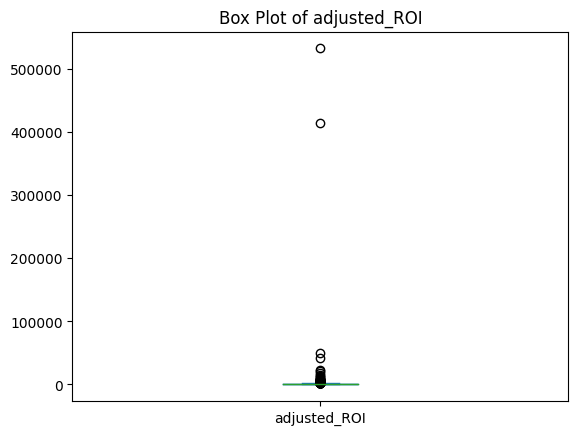

In [346]:

import matplotlib.pyplot as plt
roi_df['adjusted_ROI'].plot(kind='box')
plt.title('Box Plot of adjusted_ROI')
plt.show()


In [345]:
skewness = roi_df['adjusted_ROI'].skew()
kurtosis = roi_df['adjusted_ROI'].kurt()

skewness, kurtosis


(22.863362769803512, 536.1419470019188)

In [191]:
from scipy.stats import zscore

roi_df['ROI Z-score'] = zscore(roi_df['adjusted_ROI'])
outliers_z_score = roi_df[roi_df['ROI Z-score'].abs() > 3]

/Users/olgabraginskaya/.pyenv/versions/3.11.4/envs/ml_camp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


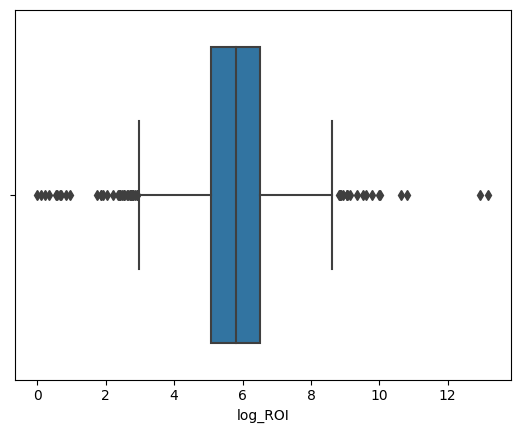

In [259]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

roi_df['log_ROI'] = roi_df['adjusted_ROI'].apply(lambda x: np.log(x + abs(roi_df['adjusted_ROI'].min()) + 1))

# Box Plot
sns.boxplot(x=roi_df['log_ROI'])
plt.show()

In [39]:
#value_counts = df["Production"].value_counts()
#value_counts
null_count = df['BoxOffice'].isnull().sum()
null_count

0

In [260]:
roi_df.describe()

,id,runtime,tmdb_popularity,tmdb_vote_average,tmdb_vote_count,metacritic_rating,imdb_rating,imdb_votes,rotten_tomatoes_rating,release_month,release_year,adjusted_ROI,numerical_ROI_category,log_ROI
count,1046.00,1046.00,1046.00,1046.00,1046.00,986.00,1046.00,1046.00,1010.00,1046.00,1046.00,1046.00,1046.00,1046.00
mean,1170.24,116.87,28.01,6.96,3735.35,65.00,7.09,255732.28,70.25,7.27,1992.96,1613.99,2.14,5.76
std,812.99,22.70,22.65,0.77,4555.20,17.13,0.90,335164.20,23.97,3.26,14.01,20988.51,1.36,1.40
min,5.00,69.00,1.95,4.05,18.00,15.00,2.90,783.00,0.00,1.00,1948.00,-99.97,0.00,0.00
25%,489.75,101.00,15.80,6.49,867.25,53.00,6.60,59354.75,55.00,5.00,1987.00,58.76,1.00,5.07
50%,924.50,114.00,22.18,7.03,1953.00,66.00,7.20,136679.00,77.00,7.00,1998.00,231.99,2.00,5.81
75%,1884.50,128.00,33.17,7.50,4636.00,78.00,7.70,311025.50,90.00,10.00,2004.00,572.60,3.00,6.51
max,2998.00,229.00,302.31,8.71,30664.00,100.00,9.30,2802199.00,100.00,12.00,2014.00,532933.94,4.00,13.19


In [261]:
import re

awards_df = roi_df.copy()

pattern = {'oscar_won': re.compile(r'won (\d+) oscar', re.IGNORECASE),
           'oscar_nominated': re.compile(r'nominated for (\d+) oscar', re.IGNORECASE),
           'bafta_won': re.compile(r'won (\d+) bafta', re.IGNORECASE),
           'bafta_nominated': re.compile(r'nominated for (\d+) bafta', re.IGNORECASE),
           'awards_won': re.compile(r'(\d+)\s*win', re.IGNORECASE),
           'awards_nominated': re.compile(r'(\d+)\s*nomination', re.IGNORECASE)}
awards_df['awards'] = awards_df['awards'].str.replace('n/a', '')
for k, v in pattern.items():
# Use str.extract() to extract the number of Oscars won
    awards_df[k] = awards_df['awards'].str.extract(v).fillna(0).astype(int)

# Split the genres column into a DataFrame of dummies
genre_dummies = awards_df['genres'].str.get_dummies(sep=', ')
awards_df = pd.concat([awards_df, genre_dummies], axis=1)
awards_df.drop(['genres'], axis=1, inplace=True)
awards_df


,id,title,original_language,spoken_languages,production_companies,production_countries,runtime,rated,tmdb_popularity,tmdb_vote_average,tmdb_vote_count,awards,metacritic_rating,imdb_rating,imdb_votes,rotten_tomatoes_rating,release_month,release_year,adjusted_ROI,ROI_category,numerical_ROI_category,log_ROI,oscar_won,oscar_nominated,bafta_won,bafta_nominated,awards_won,awards_nominated,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,history,horror,music,mystery,romance,science fiction,thriller,tv movie,war,western
0,2501,the bourne identity,en,"en,fr,de,nl,it","universal pictures,hypnotic,kalima productions,stillking films,the kennedy/marshall company","us,de,cz",119,pg-13,37.01,7.46,8631,3 wins & 6 nominations,68.00,7.80,565180.00,84.00,6,2002,256.72,Below Average Gain,2,5.88,0,0,0,0,3,6,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
1,2502,the bourne supremacy,en,"en,ru,de,it","universal pictures,the kennedy/marshall company,hypnotic,motion picture theta produktionsgesellschaft,ludlum entertainment","de,us",108,pg-13,25.65,7.32,6987,5 wins & 22 nominations,73.00,7.70,478645.00,82.00,7,2004,284.67,Below Average Gain,2,5.95,0,0,0,0,5,22,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,2503,the bourne ultimatum,en,"en,fr,ar,ru,es","universal pictures,the kennedy/marshall company,ludlum entertainment,motion picture beta produktionsgesellschaft,bourne again,kanzaman services,peninsula films,studio babelsberg","fr,de,es,us",115,pg-13,26.90,7.42,7137,won 3 oscars. 29 wins & 42 nominations total,85.00,8.00,649755.00,92.00,8,2007,532.61,Above Average Gain,3,6.45,3,0,0,0,29,42,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
12,2539,spanglish,en,"es,en","gracie films,columbia pictures",us,130,pg-13,16.82,6.00,1185,5 wins & 15 nominations,48.00,6.40,87369.00,54.00,12,2004,-31.20,Loss,0,4.25,0,0,0,0,5,15,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,2565,joe versus the volcano,en,en,"amblin entertainment,warner bros. pictures",us,102,pg,14.29,5.67,468,1 nomination,45.00,5.90,39040.00,66.00,3,1990,57.62,Low Gain,1,5.07,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,194,amélie,fr,"fr,ru","france 3 cinéma,claudie ossard productions,mmc independent,tapioca films,sofica sofinergie 5,victoires productions,canal+,filmstiftung nordrhein-westfalen,union générale cinématographique (ugc),miramax","fr,de",122,r,32.44,7.91,10767,nominated for 5 oscars. 59 wins & 74 nominations total,69.00,8.30,777290.00,89.00,4,2001,1639.22,High Gain,4,7.46,0,5,0,0,59,74,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1935,196,back to the future part iii,en,en,"universal pictures,amblin entertainment",us,119,pg,31.72,7.50,9687,5 wins & 11 nominations,55.00,7.40,468495.00,80.00,5,1990,511.32,Above Average Gain,3,6.42,0,0,0,0,5,11,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1936,197,braveheart,en,"en,fr,la,gd","icon entertainment international,the ladd company,b.h. finance c.v.",us,177,r,42.17,7.93,9355,won 5 oscars. 34 wins & 34 nominations total,68.00,8.30,1069827.00,76.00,5,1995,196.13,Below Average Gain,2,5.69,5,0,0,0,34,34,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
1938,199,star trek: first contact,en,en,paramount,us,111,pg-13,27.22,7.29,1593,nominated for 1 oscar. 8 wins & 21 nominations total,71.00,7.60,130183.00,93.00,11,1996,226.09,Below Average Gain,2,5.79,0,1,0,0,8,21,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0


In [265]:
from textblob import TextBlob

new_features_df = awards_df.copy()

new_features_df['title_sentiment'] = new_features_df['title'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [217]:
new_features_df['title_sentiment'].value_counts()

title_sentiment
0.00     874
-0.60     12
0.50      12
-0.20     11
0.25      11
0.10       9
0.35       8
0.20       6
-0.40      6
0.30       6
0.70       6
-0.17      6
-0.29      6
-0.15      5
-0.10      5
1.00       5
-1.00      4
0.60       4
0.14       4
0.40       4
-0.19      3
-0.25      3
-0.67      3
-0.05      2
-0.50      2
0.85       2
0.16       2
0.33       2
0.43       2
0.88       1
0.32       1
0.08       1
0.15       1
0.05       1
0.29       1
0.25       1
-0.16      1
0.80       1
-0.31      1
0.05       1
-0.80      1
-0.23      1
0.45       1
-0.10      1
-0.23      1
0.38       1
0.90       1
0.60       1
0.07       1
-0.70      1
Name: count, dtype: int64

In [266]:
import pandas as pd
from collections import Counter
import ast  # if needed to convert string representation of list to list

new_features_df['production_countries'] = new_features_df['production_countries'].str.split(',')
# Flatten the list of lists and count the occurrences of each country code
country_counter = Counter(country_code for country_list in new_features_df['production_countries'].dropna() for country_code in country_list)
country_counter
# Convert the Counter object to a DataFrame for easier viewing and analysis
country_frequencies = pd.DataFrame(country_counter.items(), columns=['Country Code', 'Frequency'])

# Sort the DataFrame by frequency
country_frequencies = country_frequencies.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
country_frequencies



,Country Code,Frequency
0,us,902
1,gb,194
2,fr,131
3,de,108
4,ca,41
5,it,36
6,jp,33
7,es,27
8,hk,18
9,mx,12


In [233]:
country_frequencies.head(10)

,Country Code,Frequency
0,us,635
1,us,267
2,gb,103
3,gb,91
4,fr,89
5,de,57
6,de,51
7,fr,42
8,ca,38
9,it,31


EDA

ways to create new features:
spoken_languages - or hot encoding or other variants
production_companies
production_countries

In [123]:
eda_df = df.copy()
eda_df.to_csv('eda.csv', index=False)

<Axes: ylabel='Frequency'>

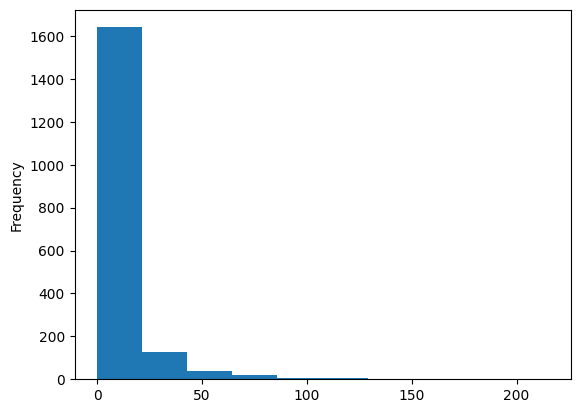

In [121]:
eda_df['awards_won'].plot(kind="hist")

In [120]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
le = LabelEncoder()

# Fit and transform the original_language column
eda_df['language_label'] = le.fit_transform(eda_df['original_language'])
eda_df[['language_label', 'original_language']]

,language_label,original_language
0,8,en
1,8,en
2,8,en
3,8,en
4,18,ja
...,...,...
1838,8,en
1839,8,en
1840,8,en
1841,8,en


In [ ]:
from sklearn.ensemble import RandomForestRegressor
#feature importance analysis
# decision tree model

dtr = RandomForestRegressor()# DecisionTreeRegressor()
dtr.fit(x_train,y_train)

feat_importances = pd.Series(dtr.feature_importances_, index=x_train.columns)
feat_importances.nlargest(len(x_train.columns)).plot(kind='barh')


In [ ]:
# need to check genres
import pandas as pd
from collections import Counter
import ast  # if needed to convert string representation of list to list

new_features_df = dataset_df.copy()
new_features_df['genres'] = new_features_df['genres'].str.split(',')
# Flatten the list of lists and count the occurrences of each country code
country_counter = Counter(country_code for country_list in new_features_df['genres'].dropna() for country_code in country_list)
country_counter
# Convert the Counter object to a DataFrame for easier viewing and analysis
country_frequencies = pd.DataFrame(country_counter.items(), columns=['genres', 'Frequency'])

# Sort the DataFrame by frequency
country_frequencies = country_frequencies.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
country_frequencies

In [334]:
import pandas as pd
import pyarrow.parquet as pq
import os

def read_parquet_files_to_dataframe(directory_path):
    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.endswith('.parquet')]
    
    # Initialize an empty list to hold DataFrames
    dataframes = []
    
    # Loop through the files and read each one into a DataFrame
    for file in files:
        file_path = os.path.join(directory_path, file)
        parquet_file = pq.ParquetFile(file_path)
        df = parquet_file.read().to_pandas()
        dataframes.append(df)
    
    # Concatenate all the DataFrames into a single DataFrame
    merged_dataframe = pd.concat(dataframes, ignore_index=True)
    
    return merged_dataframe



# Call the function
credits_dataframe = read_parquet_files_to_dataframe('credits/')
pd.set_option("max_colwidth", None)
pd.set_option('display.max_columns', None)

In [335]:
credits_df=credits_dataframe.drop_duplicates(subset=['id']).copy()
print(credits_df.shape)

(8835, 3)


In [336]:
result_df = merged_dataframe.merge(credits_dataframe, on='id', how='left')

In [337]:
result_df = result_df[result_df['crew'].notnull()]
result_df = result_df[result_df['cast'].notnull()]
result_df.shape

(6751, 61)

In [333]:
result_df['cast'] = result_df['cast'].apply(ast.literal_eval)
result_df['crew'] = result_df['crew'].apply(ast.literal_eval)


ValueError: malformed node or string: array([{'adult': False, 'cast_id': 5, 'character': 'Gary Shaller', 'credit_id': '52fe45729251416c75056cf3', 'gender': 2, 'id': 7060, 'known_for_department': 'Acting', 'name': 'Martin Freeman', 'order': 0, 'original_name': 'Martin Freeman', 'popularity': 19.926, 'profile_path': '/pLG7mmxBXXTVAgzXvQl0ap3qlJU.jpg'},
       {'adult': False, 'cast_id': 7, 'character': 'Dora Epstein', 'credit_id': '52fe45729251416c75056cfb', 'gender': 1, 'id': 12052, 'known_for_department': 'Acting', 'name': 'Gwyneth Paltrow', 'order': 1, 'original_name': 'Gwyneth Paltrow', 'popularity': 22.129, 'profile_path': '/m2xcWJvhRdfbHxDj13gTAQ5Is0d.jpg'},
       {'adult': False, 'cast_id': 1, 'character': 'Anna / Melodia', 'credit_id': '52fe45729251416c75056ce3', 'gender': 1, 'id': 955, 'known_for_department': 'Acting', 'name': 'Penélope Cruz', 'order': 2, 'original_name': 'Penélope Cruz', 'popularity': 27.431, 'profile_path': '/tU2ATiHHBAKn4SHqKOagYqdpHiy.jpg'},
       {'adult': False, 'cast_id': 8, 'character': 'Paul', 'credit_id': '52fe45729251416c75056cff', 'gender': 2, 'id': 11108, 'known_for_department': 'Acting', 'name': 'Simon Pegg', 'order': 3, 'original_name': 'Simon Pegg', 'popularity': 31.002, 'profile_path': '/nOWKXxgADG98RjKyfQ7oSDfns6J.jpg'},
       {'adult': False, 'cast_id': 2, 'character': 'Mel', 'credit_id': '52fe45729251416c75056ce7', 'gender': 2, 'id': 518, 'known_for_department': 'Acting', 'name': 'Danny DeVito', 'order': 4, 'original_name': 'Danny DeVito', 'popularity': 49.256, 'profile_path': '/6kO4IN7ndoIGw2JhyhAQN3SFmdx.jpg'},
       {'adult': False, 'cast_id': 16, 'character': 'Terry', 'credit_id': '5a2041a1c3a3680b93092a22', 'gender': 1, 'id': 59864, 'known_for_department': 'Acting', 'name': 'Amber Sealey', 'order': 5, 'original_name': 'Amber Sealey', 'popularity': 1.882, 'profile_path': '/qN4FuV0NSCOaqMijK6jGKnCCAGp.jpg'},
       {'adult': False, 'cast_id': 4, 'character': 'Shawna', 'credit_id': '52fe45729251416c75056cef', 'gender': 0, 'id': 93653, 'known_for_department': 'Acting', 'name': 'Sonia Doubell', 'order': 6, 'original_name': 'Sonia Doubell', 'popularity': 0.6, 'profile_path': None},
       {'adult': False, 'cast_id': 3, 'character': 'Karlheinz', 'credit_id': '52fe45729251416c75056ceb', 'gender': 2, 'id': 35128, 'known_for_department': 'Acting', 'name': 'Steffan Boje', 'order': 7, 'original_name': 'Steffan Boje', 'popularity': 2.686, 'profile_path': '/oidWbMcDQmY9O1jhjtpBImPjhUX.jpg'},
       {'adult': False, 'cast_id': 6, 'character': 'Alan Weigert', 'credit_id': '52fe45729251416c75056cf7', 'gender': 2, 'id': 5658, 'known_for_department': 'Acting', 'name': 'Michael Gambon', 'order': 8, 'original_name': 'Michael Gambon', 'popularity': 29.419, 'profile_path': '/3jdWkDKf4IODbG4JKTeaC7AzxZH.jpg'},
       {'adult': False, 'cast_id': 9, 'character': 'Victor', 'credit_id': '52fe45729251416c75056d03', 'gender': 2, 'id': 1115, 'known_for_department': 'Acting', 'name': 'Stephen Graham', 'order': 9, 'original_name': 'Stephen Graham', 'popularity': 24.635, 'profile_path': '/rkavERf9KK4Yvs8V4HWrTaUwoHX.jpg'},
       {'adult': False, 'cast_id': 13, 'character': 'Norman', 'credit_id': '5a2041490e0a264cbc0958d9', 'gender': 2, 'id': 20056, 'known_for_department': 'Acting', 'name': 'Keith Allen', 'order': 10, 'original_name': 'Keith Allen', 'popularity': 15.112, 'profile_path': '/1azvWtgKZ9u8oadJdsykij62X1z.jpg'},
       {'adult': False, 'cast_id': 14, 'character': 'Tica', 'credit_id': '5a2041540e0a264cc108ff90', 'gender': 1, 'id': 63606, 'known_for_department': 'Acting', 'name': 'Meredith MacNeill', 'order': 11, 'original_name': 'Meredith MacNeill', 'popularity': 2.564, 'profile_path': '/vJSWgiZIwQSqQYBVPyjD8phbqNH.jpg'},
       {'adult': False, 'cast_id': 15, 'character': 'Vivian Jesson', 'credit_id': '5a20418bc3a3680b930929fe', 'gender': 1, 'id': 199522, 'known_for_department': 'Acting', 'name': 'Amanda Abbington', 'order': 12, 'original_name': 'Amanda Abbington', 'popularity': 13.727, 'profile_path': '/diashQMD26rrZOmj342EK8a6EaQ.jpg'},
       {'adult': False, 'cast_id': 10, 'character': 'Naresta', 'credit_id': '52fe45729251416c75056d07', 'gender': 0, 'id': 93654, 'known_for_department': 'Acting', 'name': 'Juliana Kiehl', 'order': 13, 'original_name': 'Juliana Kiehl', 'popularity': 0.6, 'profile_path': None},
       {'adult': False, 'cast_id': 17, 'character': 'Studio Assistant', 'credit_id': '5a2041b90e0a264cc408e0e4', 'gender': 1, 'id': 1231232, 'known_for_department': 'Acting', 'name': 'Finty Williams', 'order': 14, 'original_name': 'Finty Williams', 'popularity': 1.663, 'profile_path': None},
       {'adult': False, 'cast_id': 18, 'character': "Gary's Neighbour", 'credit_id': '5a2041cc0e0a264cc408e0fd', 'gender': 0, 'id': 1278590, 'known_for_department': 'Acting', 'name': 'Joyce Springer', 'order': 15, 'original_name': 'Joyce Springer', 'popularity': 0.612, 'profile_path': '/3jp6GCXr8lEZWoZm7usXx8AVxq2.jpg'},
       {'adult': False, 'cast_id': 19, 'character': 'Ballerina', 'credit_id': '5a2041ec925141033008e189', 'gender': 1, 'id': 60415, 'known_for_department': 'Acting', 'name': 'Skye Bennett', 'order': 16, 'original_name': 'Skye Bennett', 'popularity': 6.597, 'profile_path': '/xgjFgBWxuiZHWVZ8h7zICz0hxb5.jpg'},
       {'adult': False, 'cast_id': 20, 'character': 'Ballet Teacher', 'credit_id': '5a20420b925141032c093534', 'gender': 1, 'id': 1497048, 'known_for_department': 'Acting', 'name': 'Kate Harper', 'order': 17, 'original_name': 'Kate Harper', 'popularity': 4.449, 'profile_path': '/uN0CA2CsywCU3ZUbZBEOCwqS8lQ.jpg'},
       {'adult': False, 'cast_id': 21, 'character': 'Chef', 'credit_id': '5a20421f0e0a264ccd094645', 'gender': 0, 'id': 1932545, 'known_for_department': 'Acting', 'name': 'Gael Le Cornec', 'order': 18, 'original_name': 'Gael Le Cornec', 'popularity': 0.98, 'profile_path': None},
       {'adult': False, 'cast_id': 22, 'character': 'Italian Slickster #1', 'credit_id': '5a2042310e0a264cbc0959fe', 'gender': 2, 'id': 26203, 'known_for_department': 'Acting', 'name': 'Bruno Lastra', 'order': 19, 'original_name': 'Bruno Lastra', 'popularity': 7.239, 'profile_path': '/sst9ejvB74G8icKfStQQGhIVw31.jpg'},
       {'adult': False, 'cast_id': 23, 'character': 'Italian Slickster #2', 'credit_id': '5a2042480e0a264ccd094667', 'gender': 2, 'id': 1794391, 'known_for_department': 'Acting', 'name': 'Martino Lazzeri', 'order': 20, 'original_name': 'Martino Lazzeri', 'popularity': 1.788, 'profile_path': None},
       {'adult': False, 'cast_id': 25, 'character': 'Italian Slickster #3', 'credit_id': '5a204282c3a3680b88093c05', 'gender': 2, 'id': 1467174, 'known_for_department': 'Acting', 'name': 'Sean Francis George', 'order': 21, 'original_name': 'Sean Francis George', 'popularity': 1.4, 'profile_path': '/Kti03TR19OyeorkjiNRajQp9dH.jpg'},
       {'adult': False, 'cast_id': 24, 'character': 'Self', 'credit_id': '5a2042690e0a264cd0092547', 'gender': 2, 'id': 107170, 'known_for_department': 'Acting', 'name': 'Jarvis Cocker', 'order': 22, 'original_name': 'Jarvis Cocker', 'popularity': 3.546, 'profile_path': '/i4EzLcmH0OPoEicgE4hasgFdkIl.jpg'},
       {'adult': False, 'cast_id': 43, 'character': 'Madan Mohan Khullar', 'credit_id': '5e75b2e4a055ef00162b9d78', 'gender': 0, 'id': 80389, 'known_for_department': 'Acting', 'name': 'Vinod Nagpal', 'order': 23, 'original_name': 'Vinod Nagpal', 'popularity': 2.284, 'profile_path': None},
       {'adult': False, 'cast_id': 44, 'character': 'Ratan', 'credit_id': '5e75b3112f3b1700174f56b9', 'gender': 0, 'id': 80390, 'known_for_department': 'Acting', 'name': 'Shivam Pradhan', 'order': 24, 'original_name': 'Shivam Pradhan', 'popularity': 1.099, 'profile_path': '/dRACUUz01xAAq2w5oYN0xGosNFs.jpg'},
       {'adult': False, 'cast_id': 45, 'character': 'Watchman', 'credit_id': '5e75b356b1f68d0017e30ab4', 'gender': 0, 'id': 80391, 'known_for_department': 'Acting', 'name': 'Manish Narang', 'order': 25, 'original_name': 'Manish Narang', 'popularity': 0.98, 'profile_path': None},
       {'adult': False, 'cast_id': 46, 'character': 'Newspaper Vendor', 'credit_id': '5e75b380cabfe400151f13bd', 'gender': 0, 'id': 80392, 'known_for_department': 'Acting', 'name': 'Abhijeet Banerjee', 'order': 26, 'original_name': 'Abhijeet Banerjee', 'popularity': 0.6, 'profile_path': None}],
      dtype=object)

In [340]:
new_features_df = result_df.copy()

def clean_cast_members(members):
    # Retain only 'name' and 'popularity' keys for each member
    return [{'name': member['name'], 'popularity': member['popularity']} for member in members]

def clean_crew_members(members):
    # Retain only 'name', 'popularity', and 'job' keys for each member
    return [{'name': member['name'], 'popularity': member['popularity'], 'job': member['job']} for member in members]


# Apply the cleaning function to 'cast' and 'crew' columns
new_features_df['cast'] = new_features_df['cast'].apply(clean_cast_members)
new_features_df['crew'] = new_features_df['crew'].apply(clean_crew_members)

# Reset index after dropping rows
new_features_df.reset_index(drop=True, inplace=True)